In [23]:
from pathlib import Path
import pandas as pd
import numpy as np

path = './avito_data/' 

files = Path(path).glob('*.csv')  

In [24]:
dfs = list()
for f in files:
    data = pd.read_csv(f)
    data['file'] = f.stem
    dfs.append(data)

df_original = pd.concat(dfs, ignore_index=True)


In [25]:
# Работаем с ценой
df_working = df_original.copy()

# Гипотеза, что у продвигаемых объявлений нереалистичная цена - уменьшаем ее на 5%

df_working['Цена'] = np.where(df_working['Продвижения'].notna(), 
                              df_working['Цена'] * 0.95, 
                              df_working['Цена'])

# Логарифмируем цену чтобы сгладить выбросы

df_working = df_working.assign(log_price=np.log1p(df_working['Цена']))
df_working = df_working.drop(['Продвижения'], axis=1)

# Убираем выбросы

top_quantile = df_working['log_price'].quantile(0.975)
low_quantile = df_working['log_price'].quantile(0.025)

print(f"Топ 2,5% значение таргета: {top_quantile.round(2)}")
print(f"Топ 97,5% значение таргета: {low_quantile.round(2)}")

df_working = df_working[(df_working['log_price']>low_quantile)&(df_working['log_price']<top_quantile)]


Топ 2,5% значение таргета: 18.26
Топ 97,5% значение таргета: 14.63


In [26]:
df_working = df_working.drop(['Пр.Всего', 'Пр.Сегод.', 'Кол-во знак.', 'Цена', 'Цена м²', 'ОбщПлощ', 'Отделка', 'Ссылка',
              'Фото шт.', 'Фото', 'Unnamed: 50', 'Unnamed: 51', 'Продавец', 'Этаж', 'Ссылка', 'Широта',  'Долгота',
              'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Метро1', 'Метро2', 'Метро3', 'Адрес', 'Улица', 
              'Область', 'Край', 'Район', 'Поселок', 'Мкр-н','Гор.Округ',
              'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59',
              'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63',
              'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67',
              'Unnamed: 68', 'Unnamed: 69', 'Unnamed: 70', 'Unnamed: 71',
              'Unnamed: 72', 'Unnamed: 73', 'Unnamed: 74', 'Unnamed: 75',
              'Unnamed: 76', 'Unnamed: 77', 'Unnamed: 78', 'Unnamed: 79',
              'Unnamed: 80', 'Unnamed: 81', 'Unnamed: 82', 'Unnamed: 83',
              'Unnamed: 84', 'Unnamed: 85', 'Unnamed: 86', 'Unnamed: 87',
              'Unnamed: 88', 'Unnamed: 89', 'Unnamed: 90', 'file', 'Время поднятия',
              'Unnamed: 49', 'Unnamed: 91', 'Unnamed: 92', 'Позиция', 'Пониж.цена', '№ объяв.', 'Заголовок',
              'Unnamed: 93'], axis=1)

# Нас интересуют только жилые дома

categories_to_keep = ['Дома', 'Коттеджи', 'Таунхаусы']
df_working = df_working[df_working['Подкатегория'].isin(categories_to_keep)]
df_working = df_working.drop(['Подкатегория'], axis=1)
category = ['индивидуальное жилищное строительство (ИЖС)']
df_working = df_working[df_working['Категория земель'].isin(category)]
df_working = df_working.drop(['Категория земель'], axis=1)


# Обработка Площ.дома

import re
def extract_number(value):
    if pd.isna(value):
        return np.nan
    match = re.search(r'\d+(?:\.\d+)?', str(value))
    if match:
        return float(match.group())
    return np.nan

df_working['Площ.дома'] = df_working['Площ.дома'].apply(extract_number).astype(float)
df_working = df_working[df_working['Площ.дома'].notna()]

# Обработка Площ.участка

df_working['Площ.Участка'] = df_working['Площ.Участка'].apply(extract_number).astype(float)
df_working = df_working[df_working['Площ.Участка'].notna()]

# Кодируем Санузел

def encode_sanuzels(value):
    if pd.isna(value):
        return np.nan
    elif 'на улице' in value and 'в доме' in value:
        return 2
    elif 'в доме' in value:
        return 1
    elif 'на улице' in value:
        return 0
    else:
        return np.nan
    
df_working['Санузел'] = df_working['Санузел'].apply(encode_sanuzels)
df_working = df_working[df_working['Санузел'].notna()]

# Кодируем наличие бани/бассейна

def encode_amenities(row):
    description = str(row['Описание']).lower()
    for_leisure = str(row['Для отдыха']).lower() if pd.notna(row['Для отдыха']) else ''
    
    has_banya = 1 if ('баня' in description or 'баня' in for_leisure or 'сауна' in description or 'сауна' in for_leisure) else 0
    has_pool = 1 if ('бассейн' in description or 'бассейн' in for_leisure) else 0
    
    return pd.Series({'Есть_баня': has_banya, 'Есть_бассейн': has_pool})

df_working[['Есть_баня', 'Есть_бассейн']] = df_working.apply(encode_amenities, axis=1)
df_working = df_working.drop('Для отдыха', axis=1)

# Кодируем наличие инфраструктуры

def encode_infrastructure(row):
    description = str(row['Описание']).lower()
    infrastructure = str(row['Инфраструктура']).lower() if pd.notna(row['Инфраструктура']) else ''
    
    has_shop = 1 if ('магазин' in description or 'магазин' in infrastructure) else 0
    has_pharmacy = 1 if ('аптек' in description or 'аптека' in infrastructure) else 0
    has_kindergarten = 1 if ('детский сад' in description or 'детский сад' in infrastructure) else 0
    has_school = 1 if ('школ' in description or 'школа' in infrastructure) else 0
    
    return pd.Series({'Есть_магазин': has_shop, 'Есть_аптека': has_pharmacy, 'Есть_детский_сад': has_kindergarten, 'Есть_школа': has_school})

df_working[['Есть_магазин', 'Есть_аптека', 'Есть_детский_сад', 'Есть_школа']] = df_working.apply(encode_infrastructure, axis=1)
df_working = df_working.drop('Инфраструктура', axis=1)

# Кодируем наличие ТВ/WiFi

def tv_wifi_func(row):
    description = str(row['Описание']).lower()
    tv_wifi = str(row['Интернет/ТВ']).lower() if pd.notna(row['Интернет/ТВ']) else ''
    
    has_tv = 1 if ('телевидение' in description or 'телевидение' in tv_wifi) else 0
    has_wifi = 1 if ('wi-fi' in description or 'wi-fi' in tv_wifi or 'интернет' in description or 'вайфай' in description) else 0
    
    return pd.Series({'Есть_wifi': has_wifi, 'Есть_tv': has_tv})

df_working[['Есть_wifi', 'Есть_tv']] = df_working.apply(tv_wifi_func, axis=1)
df_working = df_working.drop('Интернет/ТВ', axis=1)

# Кодируем Кол-во Комнат

def encode_rooms(value):
    if value == 'Свободная планировка':
        return np.nan
    elif value == '10 и больше':
        return 10.0
    else:
        try:
            return float(value)
        except ValueError:
            return np.nan

df_working['Кол-воКомн_encoded'] = df_working['Кол-воКомн'].apply(encode_rooms)
df_working['Свободная_планировка'] = (df_working['Кол-воКомн'] == 'Свободная планировка').astype(int)
median_rooms = df_working['Кол-воКомн_encoded'].median()
df_working['Кол-воКомн_encoded'].fillna(median_rooms, inplace=True)
df_working = df_working.drop('Кол-воКомн', axis=1)

# Кодируем ремонт

df_working = df_working.dropna(subset=['Ремонт'])
repair_dummies = pd.get_dummies(df_working['Ремонт'], prefix='Ремонт')
df_working = pd.concat([df_working, repair_dummies], axis=1)
df_working = df_working.drop('Ремонт', axis=1)

# Кодируем МатериалСтен

target_encoded_columns = ['МатериалСтен']
for col in target_encoded_columns:
    df_working = df_working[df_working[col].notna()]
    mean_target = df_working.groupby(col)['log_price'].mean()
    df_working[col] = df_working[col].map(mean_target)
    
# Кодируем парковку

def parking_func(row):
    description = str(row['Описание']).lower()
    parking = str(row['Парковка']).lower() if pd.notna(row['Парковка']) else ''
    
    has_parking = 1 if ('парковочное' in description or 'парковочное' in parking  or 'парковк' in description) else 0
    has_garage = 1 if ('гараж' in description or 'гараж' in parking) else 0
    
    return pd.Series({'Есть_парковка': has_parking, 'Есть_гараж': has_garage})

df_working[['Есть_парковка', 'Есть_гараж']] = df_working.apply(parking_func, axis=1)
df_working = df_working.drop('Парковка', axis=1)

# Возможность ипотеки

def mortgage_func(row):
    mortgage = str(row['Способ продажи']).lower() if pd.notna(row['Способ продажи']) else ''
    mortgage_available = 1 if ('возможна ипотека' in mortgage) else 0
    return pd.Series({'Возможна_ипотека': mortgage_available})

df_working[['Возможна_ипотека']] = df_working.apply(mortgage_func, axis=1)
df_working = df_working.drop('Способ продажи', axis=1)

# Есть балкон

def terrace_func(row):
    description = str(row['Описание']).lower()
    terrace = str(row['Терраса или веранда']).lower() if pd.notna(row['Терраса или веранда']) else ''
    
    has_terrace = 1 if ('веранд' in description or 'есть' in terrace  or 'террас' in description or 'балкон' in description) else 0
    return pd.Series({'Есть_терраса': has_terrace})

df_working[['Есть_терраса']] = df_working.apply(terrace_func, axis=1)
df_working = df_working.drop('Терраса или веранда', axis=1)

# Транспортная доступность

def encode_transport(value):
    if pd.isna(value):
        return [0, 0, 0]
    value = value.lower()
    asphalt = 1 if 'асфальтированная дорога' in value else 0
    public_transport = 1 if 'остановка общественного транспорта' in value else 0
    railway = 1 if 'железнодорожная станция' in value else 0
    return [asphalt, public_transport, railway]

df_working[['Есть_асфальт', 'Есть_общ_транспорт', 'Есть_жд']] = df_working['Транспортная доступность'].apply(encode_transport).tolist()
df_working = df_working.drop('Транспортная доступность', axis=1)

# Обработка года постройки

from datetime import datetime

current_year = datetime.now().year
min_allowed_year = current_year - 20

def process_year(year):
    if pd.isna(year):
        return np.nan
    try:
        year = float(year)
        if year > current_year or year < min_allowed_year:
            return np.nan
        return year
    except ValueError:
        return np.nan

df_working['ГодПостр'] = df_working['ГодПостр'].apply(process_year)
median_year = df_working['ГодПостр'].median()
df_working['ГодПостр'] = df_working['ГодПостр'].fillna(median_year)
df_working['ГодПостр'] = df_working['ГодПостр'].astype(int)

df_working['ВозрастДома'] = current_year - df_working['ГодПостр']
df_working = df_working.drop('ГодПостр', axis=1)

# Кодируем Коммуникации

def utils_func(row):
    description = str(row['Описание']).lower()
    utils = str(row['Коммуникации']).lower() if pd.notna(row['Коммуникации']) else ''
    
    has_elec = 1 if ('электричество' in description or 'электричество' in utils) else 0
    has_heat = 1 if ('отопление' in description or 'отопление' in utils) else 0
    has_gas = 1 if ('газ' in description or 'газ' in utils ) else 0
    has_sew = 1 if ('канализация' in description or 'канализация' in utils ) else 0

    return pd.Series({'Есть_электричество': has_elec, 'Есть_отопление': has_heat, 'Есть_газ': has_gas, 'Есть_канализация': has_sew})

df_working[['Есть_электричество', 'Есть_газ', 'Есть_отопление', 'Есть_канализация']] = df_working.apply(utils_func, axis=1)
df_working = df_working.drop('Коммуникации', axis=1)

# Кодируем расстояние до МКАД

df_working['Есть_расстояние_от_МКАД'] = df_working['Расстояние от МКАД'].notna().astype(int)
df_working = df_working.drop('Расстояние от МКАД', axis=1)

# Кодируем расстояние до Центра

df_working['Расстояние до центра города'] = df_working['Расстояние до центра города'].apply(extract_number).astype(float)
def encode_distance_to_city_center(distance):
    if pd.isna(distance):
        return 'Нет данных'
    if distance < 17:
        return 'Близко к городу'
    else:
        return 'Далеко от города'

df_working['Расстояние_до_центра_города'] = df_working['Расстояние до центра города'].apply(encode_distance_to_city_center)
df_working = pd.get_dummies(df_working, columns=['Расстояние_до_центра_города'], prefix='Расст_центр')
df_working = df_working.drop('Расстояние до центра города', axis=1)

# Добавляем корректное название региона (Изначально спарсилось некорректно) + добавляем население

df_city_data = pd.read_csv('./additional_data/city_population.csv')

region_dict = dict(zip(df_city_data['settlement'], df_city_data['region']))
population_dict = dict(zip(df_city_data['settlement'], df_city_data['population']))

df_working['Регион'] = df_working['Город'].map(region_dict)
df_working['Население'] = df_working['Город'].map(population_dict)

df_working = df_working.dropna(subset=['Регион'])

# Добавим группировку по округам и данные о зарплате в регионе - обучим сверху lightGBM
df_salary_data = pd.read_csv('./additional_data/salary_region.csv')

okrug = dict(zip(df_salary_data['Регион'], df_salary_data['Округ']))
salary = dict(zip(df_salary_data['Регион'], df_salary_data['ЗП']))

df_working['Округ'] = df_working['Регион'].map(okrug)
df_working['ЗП'] = df_working['Регион'].map(salary)

# Удаляем ненужные колонки

df_working = df_working.drop(['Описание'], axis=1)

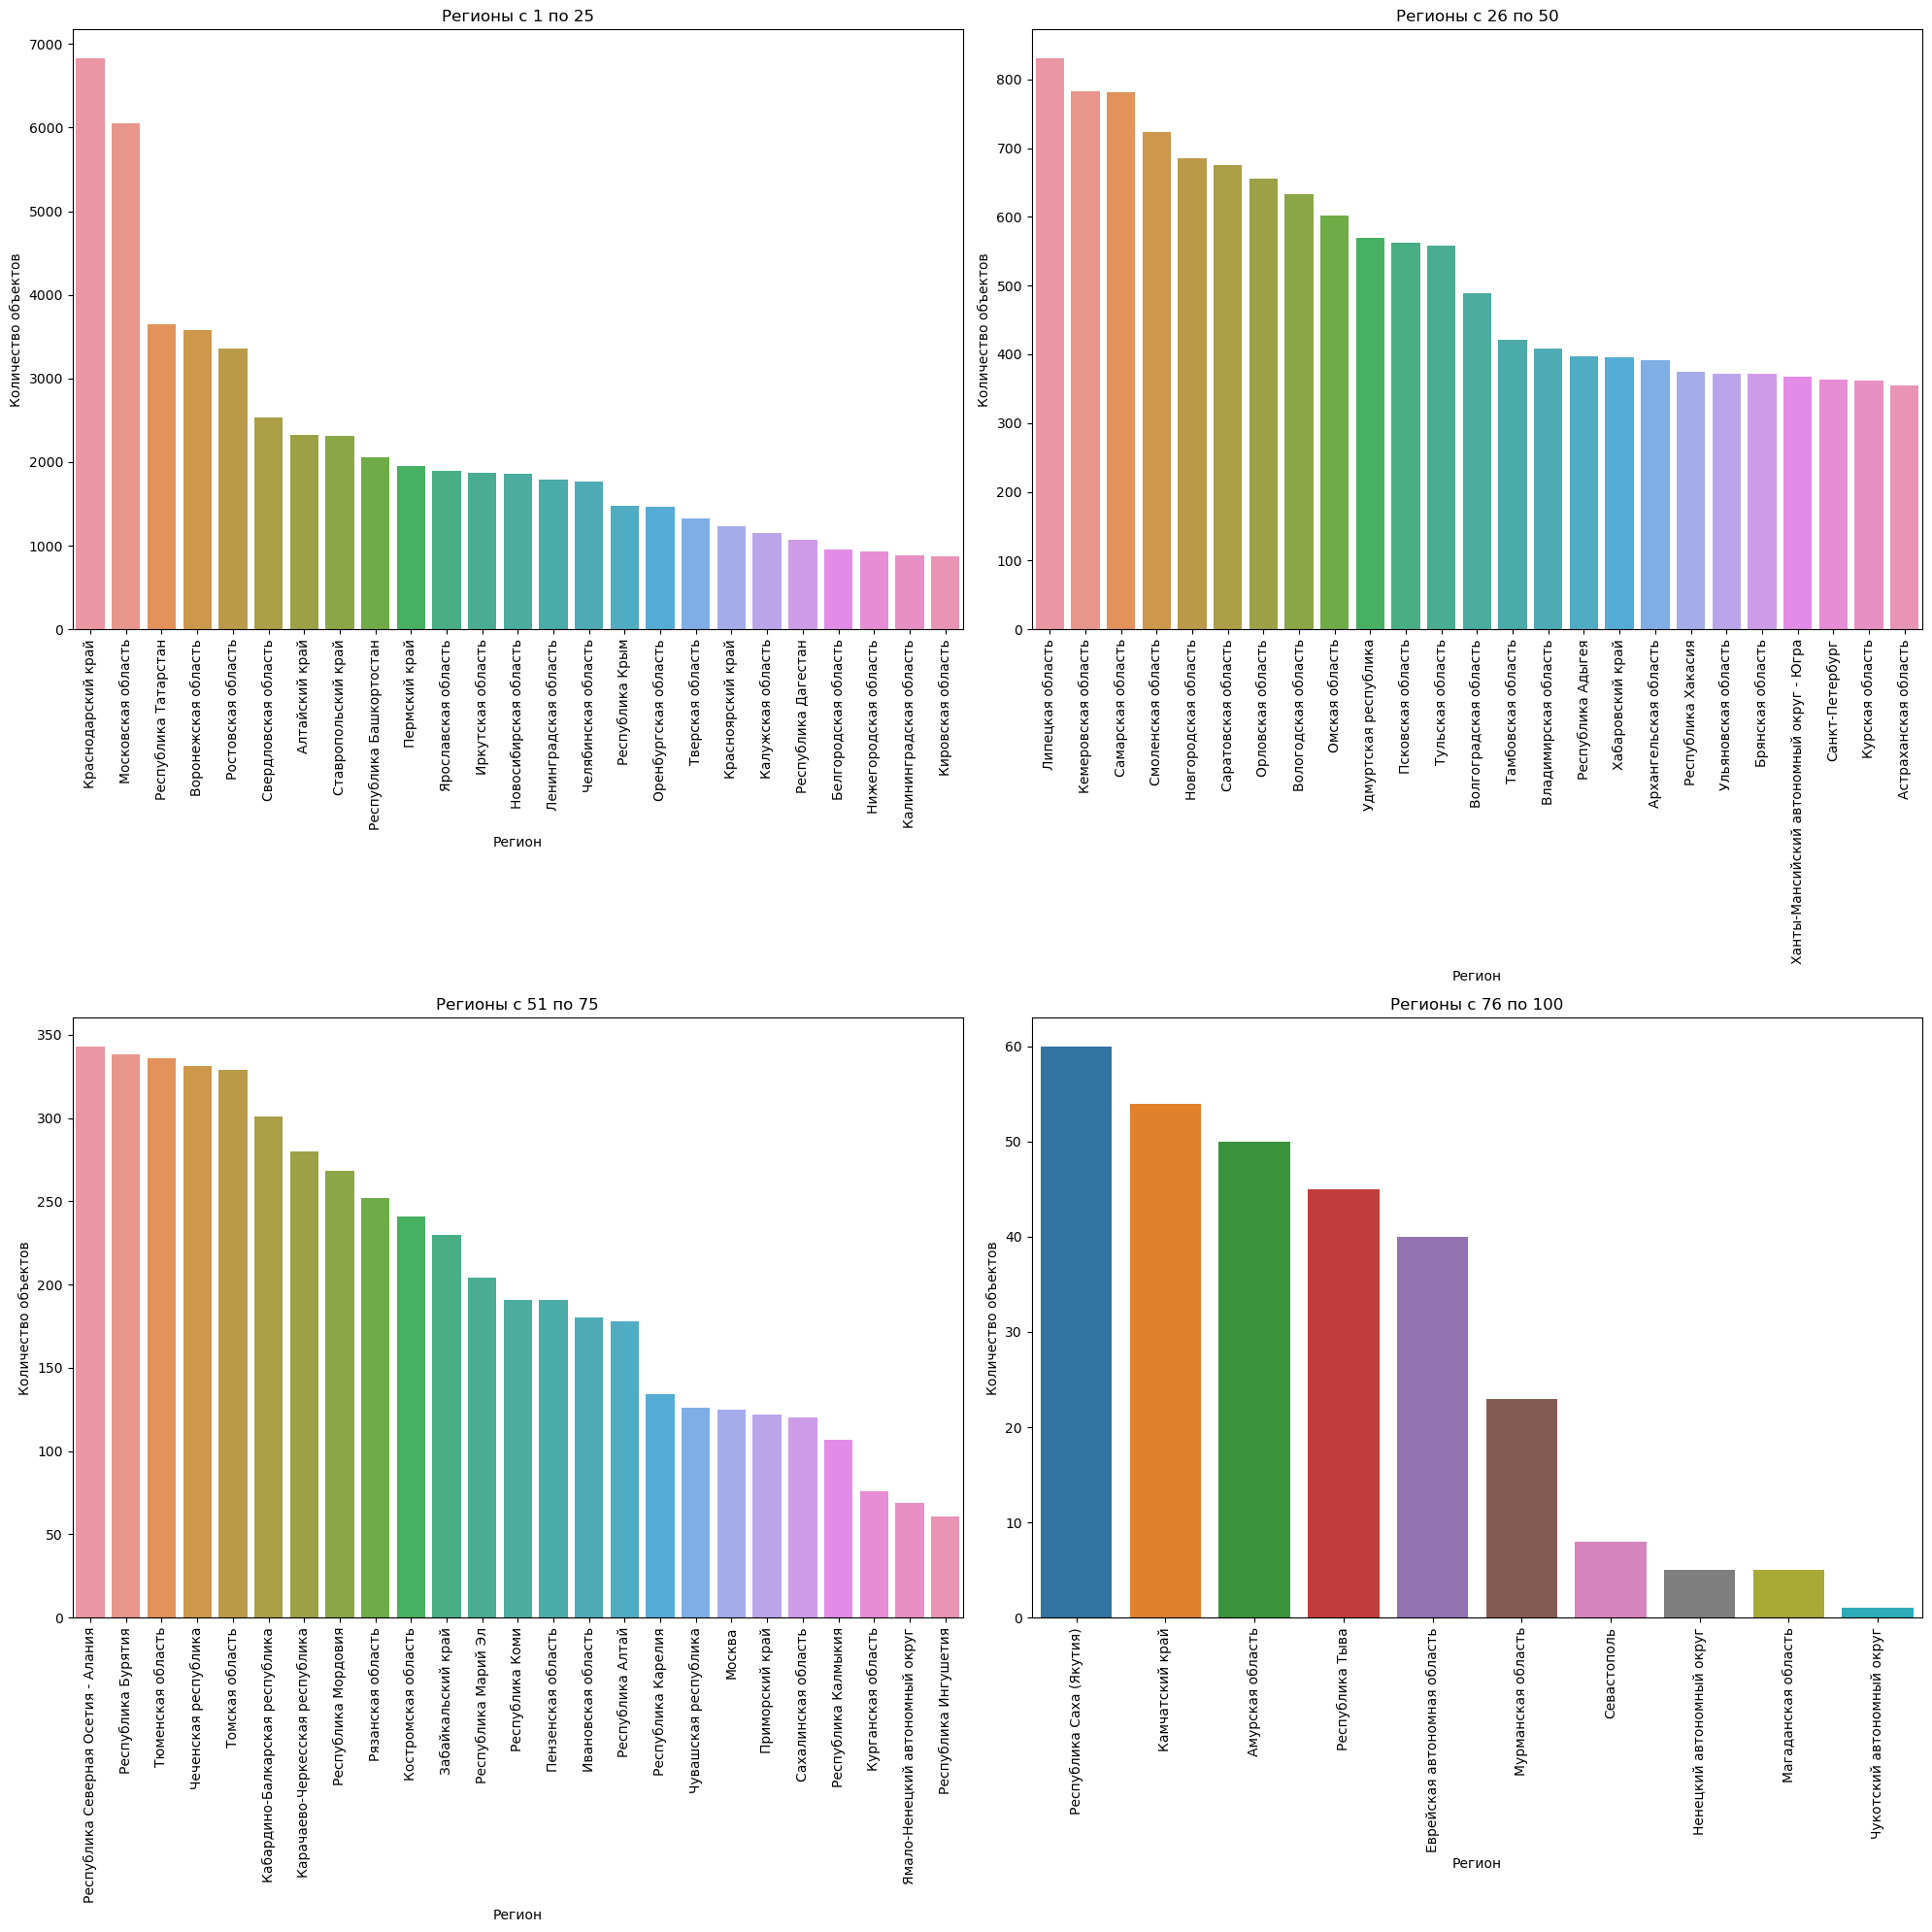

Всего уникальных регионов: 85

Топ-100 регионов:
Регион
Краснодарский край            6833
Московская область            6058
Республика Татарстан          3643
Воронежская область           3579
Ростовская область            3364
                              ... 
Мурманская область              23
Севастополь                      8
Ненецкий автономный округ        5
Магаданская область              5
Чукотский автономный округ       1
Name: count, Length: 85, dtype: int64

Процент объектов в топ-100 регионах: 100.00%


In [27]:
# Смотрим распределение по регионам
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Получаем значения счетчика регионов
region_counts = df_working['Регион'].value_counts()

# Берем топ-100 регионов
top_100 = region_counts.head(100)

# Создаем 4 подграфика для отображения по 25 регионов в каждом
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()  # Преобразуем 2D массив осей в 1D для удобства

for i in range(4):
    start = i * 25
    end = start + 25
    data = top_100.iloc[start:end]
    
    sns.barplot(x=data.index, y=data.values, ax=axes[i])
    axes[i].set_title(f'Регионы с {start+1} по {end}')
    axes[i].set_xlabel('Регион')
    axes[i].set_ylabel('Количество объектов')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Вывод статистики
print(f"Всего уникальных регионов: {region_counts.shape[0]}")
print("\nТоп-100 регионов:")
print(top_100)

# Расчет процента объектов в топ-100 регионах
total_objects = region_counts.sum()
top_100_objects = top_100.sum()
percentage = (top_100_objects / total_objects) * 100

print(f"\nПроцент объектов в топ-100 регионах: {percentage:.2f}%")

In [28]:
# Воспользуемся AutoGluon Tabular для выбора лучшей модели

from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split


# Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(df_working, test_size=0.2, random_state=42)

autogluon_automl = TabularPredictor(label='log_price', problem_type='regression', eval_metric='mean_squared_error')

autogluon_automl.fit(train_data=train)

autogluon_automl.leaderboard()


No path specified. Models will be saved in: "AutogluonModels/ag-20240701_082759"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:27:24 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T6000
CPU Count:          8
Memory Avail:       4.65 GB / 16.00 GB (29.1%)
Disk Space Avail:   150.55 GB / 460.43 GB (32.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Defau

[1000]	valid_set's l2: 0.132885
[2000]	valid_set's l2: 0.127487
[3000]	valid_set's l2: 0.125613
[4000]	valid_set's l2: 0.12477
[5000]	valid_set's l2: 0.124656
[6000]	valid_set's l2: 0.124398
[7000]	valid_set's l2: 0.124455


	-0.1244	 = Validation score   (-mean_squared_error)
	32.1s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 0.127373
[2000]	valid_set's l2: 0.125981
[3000]	valid_set's l2: 0.125632


	-0.1256	 = Validation score   (-mean_squared_error)
	14.71s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1543	 = Validation score   (-mean_squared_error)
	19.31s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1223	 = Validation score   (-mean_squared_error)
	128.39s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.167	 = Validation score   (-mean_squared_error)
	10.8s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1432	 = Validation score   (-mean_squared_error)
	43.86s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.134	 = Validation score   (-mean_squared_error)
	16.38s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1542	 = Validation score   (-mean_squared_error)
	38.09s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLar

[1000]	valid_set's l2: 0.123721
[2000]	valid_set's l2: 0.122297
[3000]	valid_set's l2: 0.121621
[4000]	valid_set's l2: 0.121259
[5000]	valid_set's l2: 0.121099
[6000]	valid_set's l2: 0.121216


	-0.1211	 = Validation score   (-mean_squared_error)
	68.97s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'CatBoost': 0.368, 'LightGBMLarge': 0.368, 'KNeighborsDist': 0.105, 'LightGBMXT': 0.105, 'NeuralNetFastAI': 0.053}
	-0.1142	 = Validation score   (-mean_squared_error)
	0.03s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 375.58s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 4272.2 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240701_082759")


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.114177,mean_squared_error,0.585173,273.363535,0.000244,0.030566,2,True,12
1,LightGBMLarge,-0.121083,mean_squared_error,0.261591,68.966767,0.261591,68.966767,1,True,11
2,CatBoost,-0.122315,mean_squared_error,0.033100,128.388586,0.033100,128.388586,1,True,6
3,LightGBMXT,-0.124379,mean_squared_error,0.260862,32.098020,0.260862,32.098020,1,True,3
4,LightGBM,-0.125554,mean_squared_error,0.084363,14.711079,0.084363,14.711079,1,True,4
5,XGBoost,-0.133986,mean_squared_error,0.081285,16.381196,0.081285,16.381196,1,True,9
6,NeuralNetFastAI,-0.143157,mean_squared_error,0.022534,43.861102,0.022534,43.861102,1,True,8
7,NeuralNetTorch,-0.154210,mean_squared_error,0.012694,38.091063,0.012694,38.091063,1,True,10
8,RandomForestMSE,-0.154304,mean_squared_error,0.050795,19.309464,0.050795,19.309464,1,True,5
9,ExtraTreesMSE,-0.167038,mean_squared_error,0.051684,10.803338,0.051684,10.803338,1,True,7


In [29]:
autogluon_automl.evaluate(test)

{'mean_squared_error': -0.11211826226721286,
 'root_mean_squared_error': -0.3348406520529024,
 'mean_absolute_error': -0.24998155982833872,
 'r2': 0.7548337600994224,
 'pearsonr': 0.8692461421224638,
 'median_absolute_error': -0.18811007630786136}

In [30]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Подготовка данных
X = df_working.drop('log_price', axis=1)
y = df_working['log_price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение категориальных признаков
cat_features = ['Регион', 'Город', 'Округ']  # Добавьте сюда другие категориальные признаки, если они есть

# Создание и настройка модели CatBoost
model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=False
)

# Обучение модели
model.fit(X_train, y_train, cat_features=cat_features)

# Предсказания на обучающем и тестовом наборах
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Вычисление RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"RMSE на обучающем наборе: {train_rmse:.4f}")
print(f"RMSE на тестовом наборе: {test_rmse:.4f}")

# Automl RMSE 0.33484 Catboost default params 0.3551

RMSE на обучающем наборе: 0.3309
RMSE на тестовом наборе: 0.3558


In [31]:

import lightgbm as lgb

df_lightGBM = df_working.copy()
okrug_dummies = pd.get_dummies(df_working['Округ'], prefix='', drop_first=True)
region_dummies = pd.get_dummies(df_working['Регион'], prefix='Регион', drop_first=True)
gorod_dummies = pd.get_dummies(df_working['Город'], prefix='Регион', drop_first=True)

df_lightGBM = pd.concat([df_working, okrug_dummies, region_dummies, gorod_dummies], axis=1)

df_lightGBM = df_working.drop(['Округ', 'Регион', 'Город'], axis=1)

# Подготовка данных
X = df_lightGBM.drop('log_price', axis=1)
y = df_lightGBM['log_price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание датасетов LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Параметры модели
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbose': 0
}

# Обучение модели
model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data], 
                   )

# Предсказания на обучающем и тестовом наборах
train_predictions = model.predict(X_train, num_iteration=model.best_iteration)
test_predictions = model.predict(X_test, num_iteration=model.best_iteration)

# Вычисление RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"RMSE на обучающем наборе: {train_rmse:.4f}")
print(f"RMSE на тестовом наборе: {test_rmse:.4f}")

# Модель переобучилась  
# ошибка хуже чем в catboost с дефолтными парамтерами - отказываемся от использования данной модели

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
RMSE на обучающем наборе: 0.2829
RMSE на тестовом наборе: 0.3673


Cross-validation RMSE scores: [0.50837849 0.63193076 0.47495206 0.48089764 0.40087207]
Mean RMSE: 0.4994 (+/- 0.1504)

Top 20 most important features:
                         feature  importance
0                      Площ.дома    0.247628
31       Есть_расстояние_от_МКАД    0.097617
3                   МатериалСтен    0.096928
15           Ремонт_дизайнерский    0.096321
11                     Есть_wifi    0.082629
35                     Население    0.068792
4                     Кол-воЭтаж    0.067141
17          Ремонт_косметический    0.063528
6                   Есть_бассейн    0.053084
18        Ремонт_требует ремонта    0.046865
22                  Есть_терраса    0.046649
16                   Ремонт_евро    0.045391
1                   Площ.Участка    0.042804
34        Расст_центр_Нет данных    0.037181
12                       Есть_tv    0.036075
33  Расст_центр_Далеко от города    0.031782
19                 Есть_парковка    0.028808
2                        Санузел    0.0

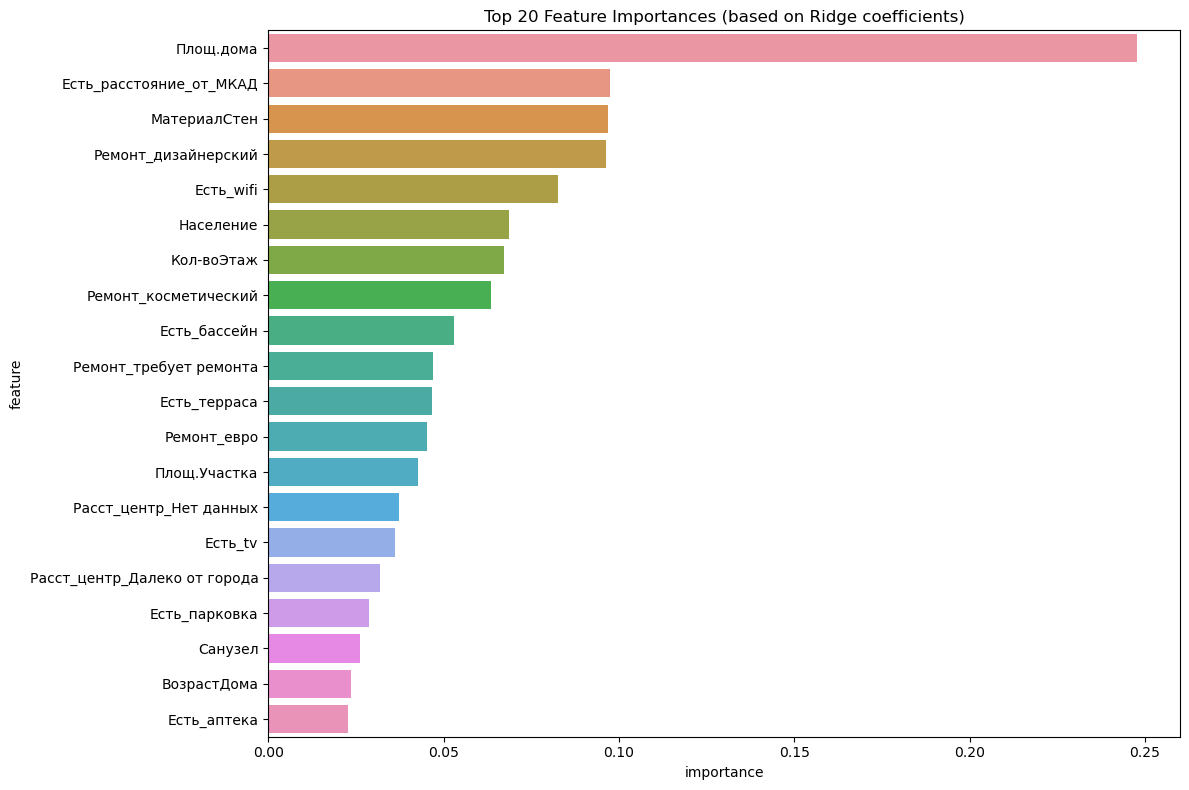

In [32]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge(alpha=1.0, max_iter=100000))  # Вы можете настроить alpha
])

# Кросс-валидация
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-cv_scores)

print(f"Cross-validation RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")

# Обучаем модель на всем датасете
pipe.fit(X, y)

# Получаем коэффициенты Ridge регрессии
coefficients = pipe.named_steps['ridge'].coef_

# Создаем DataFrame с абсолютными значениями коэффициентов
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(coefficients)
}).sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importance_df.head(20))

# Визуализируем важность признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances (based on Ridge coefficients)')
plt.tight_layout()
plt.show()

Cross-validation RMSE scores: [0.4334459  0.54103852 0.42205527 0.40406015 0.34629012]
Mean RMSE: 0.4294 (+/- 0.1268)

Top 20 most important features:
                    feature  importance
0                 Площ.дома    0.383516
35                Население    0.105959
1              Площ.Участка    0.070357
36                       ЗП    0.059435
15      Ремонт_дизайнерский    0.039626
26              ВозрастДома    0.037260
3              МатериалСтен    0.035291
31  Есть_расстояние_от_МКАД    0.028990
13       Кол-воКомн_encoded    0.025952
16              Ремонт_евро    0.023994
34   Расст_центр_Нет данных    0.019158
4                Кол-воЭтаж    0.012784
11                Есть_wifi    0.012034
22             Есть_терраса    0.009616
6              Есть_бассейн    0.008953
21         Возможна_ипотека    0.008852
19            Есть_парковка    0.008744
29           Есть_отопление    0.007604
20               Есть_гараж    0.007151
5                 Есть_баня    0.006848


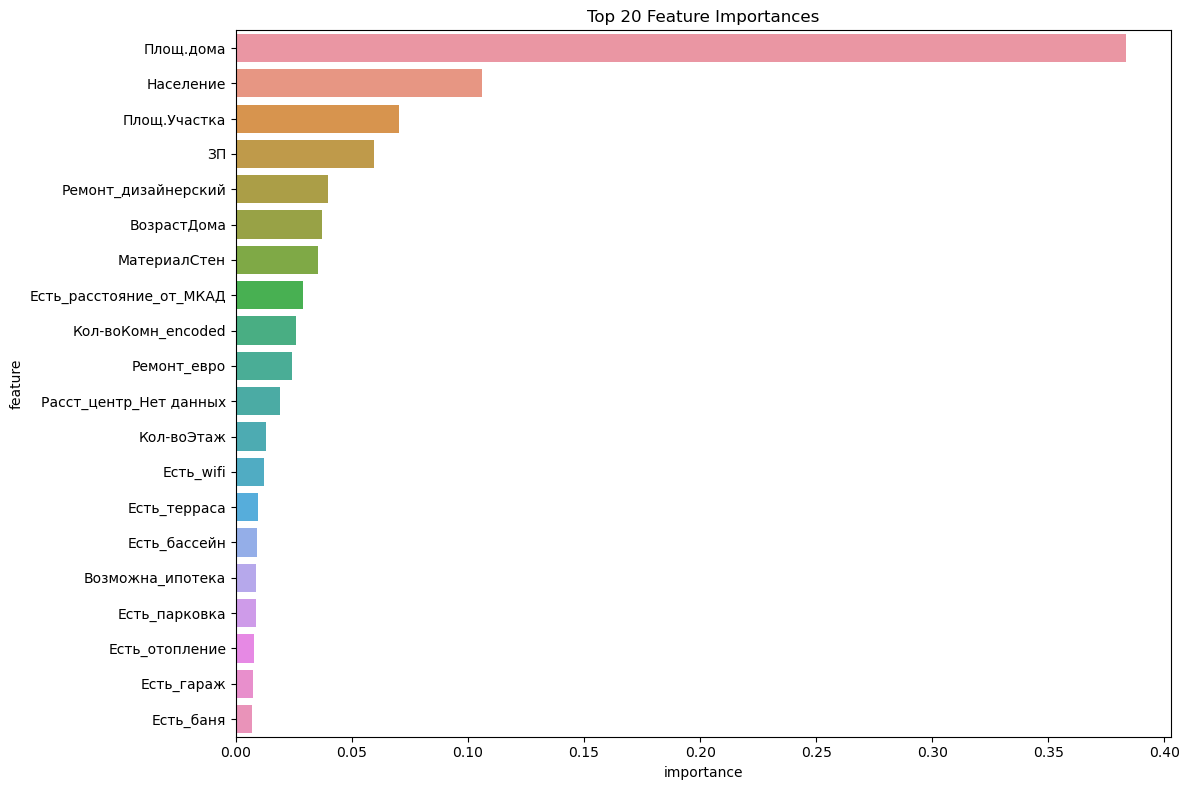

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Create a pipeline with scaling and Random Forest
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, random_state=42)
)

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert MSE to RMSE
rmse_scores = np.sqrt(-cv_scores)

print(f"Cross-validation RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")

# Fit the model on the entire dataset to get feature importances
pipeline.fit(X, y)
feature_importances = pipeline.named_steps['randomforestregressor'].feature_importances_

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importance_df.head(20))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.6s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.6s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.6s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.6s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.6s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.7s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.7s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.7s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.4s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   1.5s
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate

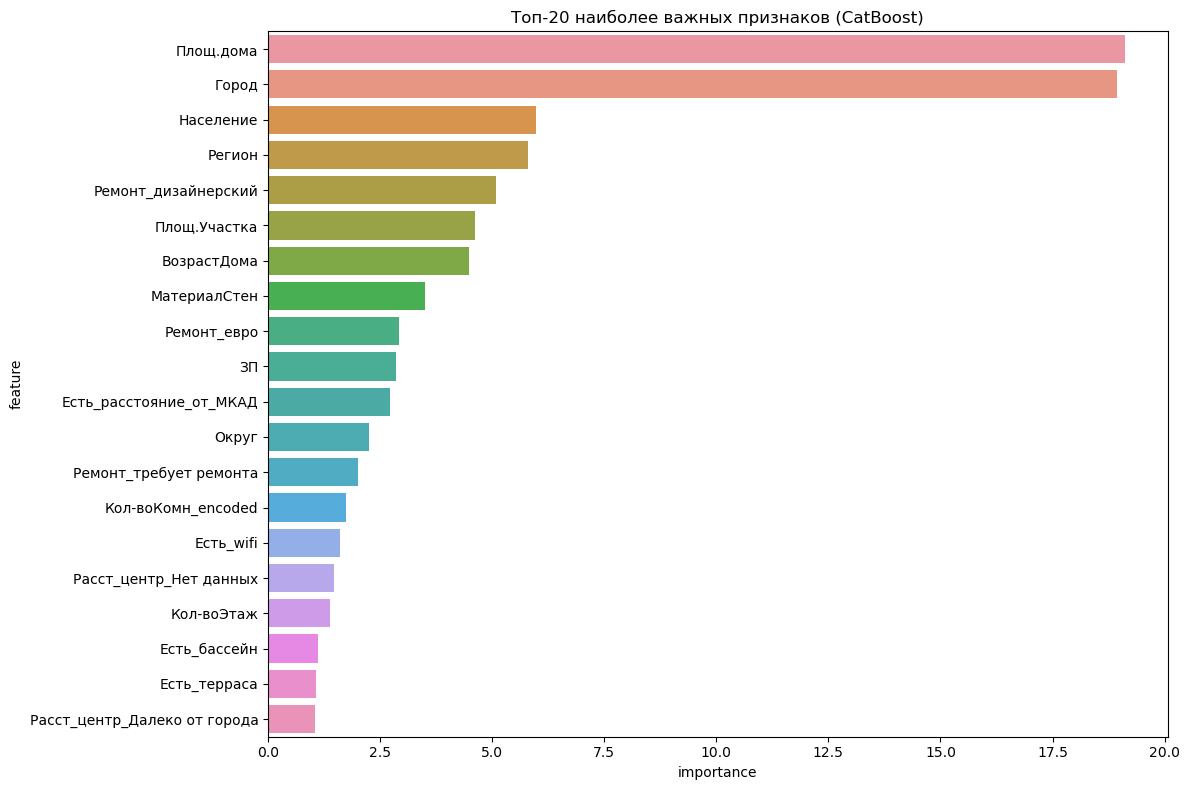

In [34]:
# Сделаем подбор гиперпараметров catboost

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Определение категориальных признаков
cat_features = ['Регион', 'Город', 'Округ']  # Добавьте сюда другие категориальные признаки, если они есть

# Создание базовой модели CatBoost
model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=False
)

# Определение параметров для поиска
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [100, 200, 300]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Подготовка данных
X = df_working.drop('log_price', axis=1)
y = df_working['log_price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Выполнение поиска по сетке
grid_search.fit(X_train, y_train, cat_features=cat_features)

# Вывод лучших параметров
print("Лучшие параметры:")
print(grid_search.best_params_)

# Получение лучшей модели
best_model = grid_search.best_estimator_

# Предсказания на тестовом наборе
y_pred = best_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE на тестовом наборе: {rmse:.4f}")
print(f"R2 на тестовом наборе: {r2:.4f}")

# Вывод важности признаков
feature_importance = best_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nТоп-20 наиболее важных признаков:")
print(feature_importance_df.head(20))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Топ-20 наиболее важных признаков (CatBoost)')
plt.tight_layout()
plt.show()

In [35]:
print("Лучшие параметры:")
print(grid_search.best_params_)

# Получение лучшей модели
best_model = grid_search.best_estimator_

# Предсказания на тестовом наборе
y_pred = best_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"RMSE на тестовом наборе: {rmse:.4f}")
print(f"R2 на тестовом наборе: {r2:.4f}")

# Лучше всего показал себя катбуст с дефолтными параметрами и AutoML


Лучшие параметры:
{'depth': 8, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
RMSE на тестовом наборе: 0.3565
R2 на тестовом наборе: 0.7220


In [39]:
# Анализ метрик autogluon

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Получаем предсказания на тестовом наборе
y_pred = autogluon_automl.predict(test)
y_true = test['log_price']

# Рассчитываем метрики
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("Метрики качества:")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Рассчитываем ошибку в рублях
y_true_exp = np.expm1(y_true)
y_pred_exp = np.expm1(y_pred)

mae_rub = mean_absolute_error(y_true_exp, y_pred_exp)

print(f"\nСредняя абсолютная ошибка в рублях: {mae_rub:,.2f}")

# Рассчитываем процентную ошибку
mape = np.mean(np.abs((y_true_exp - y_pred_exp) / y_true_exp)) * 100

print(f"\nСредняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")

# Оценка совокупной метрики качества
# Нормализуем RMSE и R2 и вычислим их среднее
normalized_rmse = rmse / np.mean(y_true)
normalized_r2 = 1 - r2  # Инвертируем R2, чтобы меньше было лучше
composite_score = (normalized_rmse + normalized_r2) / 2

print(f"\nСовокупная метрика качества: {composite_score:.4f}")

Метрики качества:
RMSE: 0.3348
R2: 0.7548

Средняя абсолютная ошибка в рублях: 3,395,266.23

Средняя абсолютная процентная ошибка (MAPE): 25.88%

Совокупная метрика качества: 0.1330


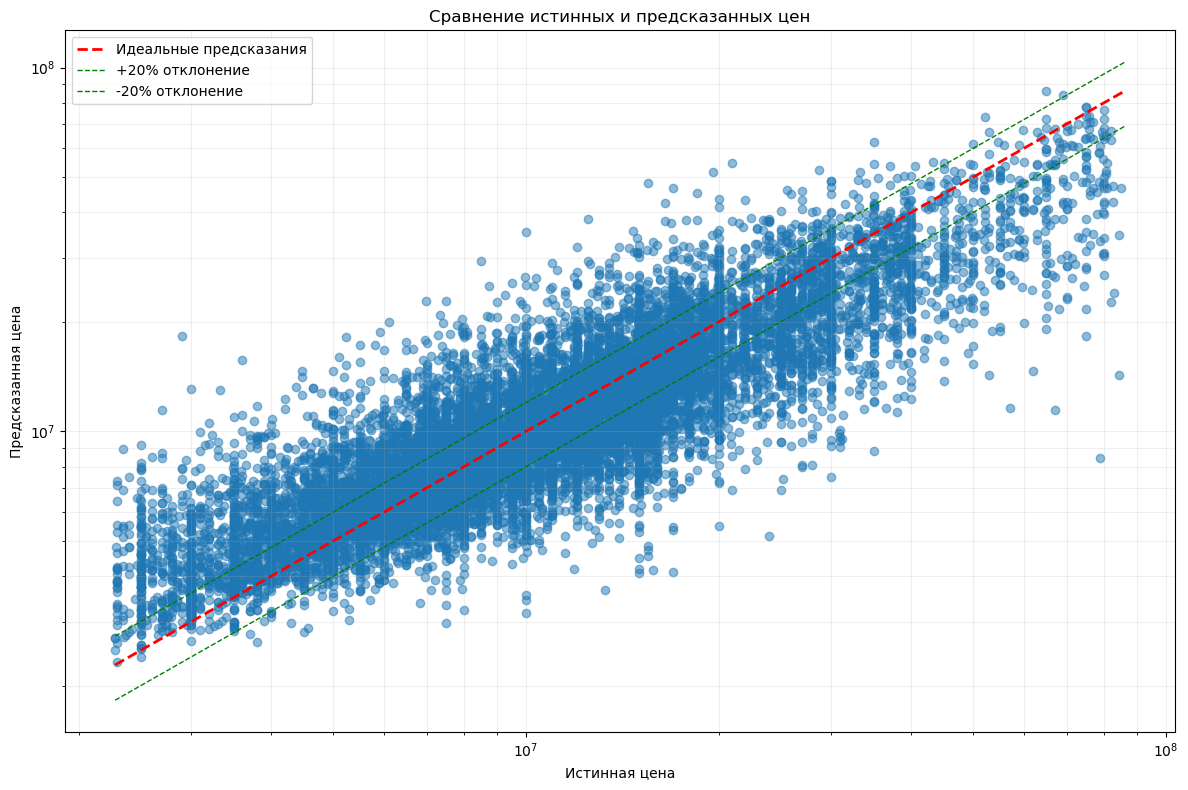

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# Основной график
plt.scatter(y_true_exp, y_pred_exp, alpha=0.5)

# Линия идеальных предсказаний
min_val = min(y_true_exp.min(), y_pred_exp.min())
max_val = max(y_true_exp.max(), y_pred_exp.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальные предсказания')

# Линии отклонения на 20%
plt.plot([min_val, max_val], [min_val*1.2, max_val*1.2], 'g--', lw=1, label='+20% отклонение')
plt.plot([min_val, max_val], [min_val*0.8, max_val*0.8], 'g--', lw=1, label='-20% отклонение')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Истинная цена")
plt.ylabel("Предсказанная цена")
plt.title("Сравнение истинных и предсказанных цен")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

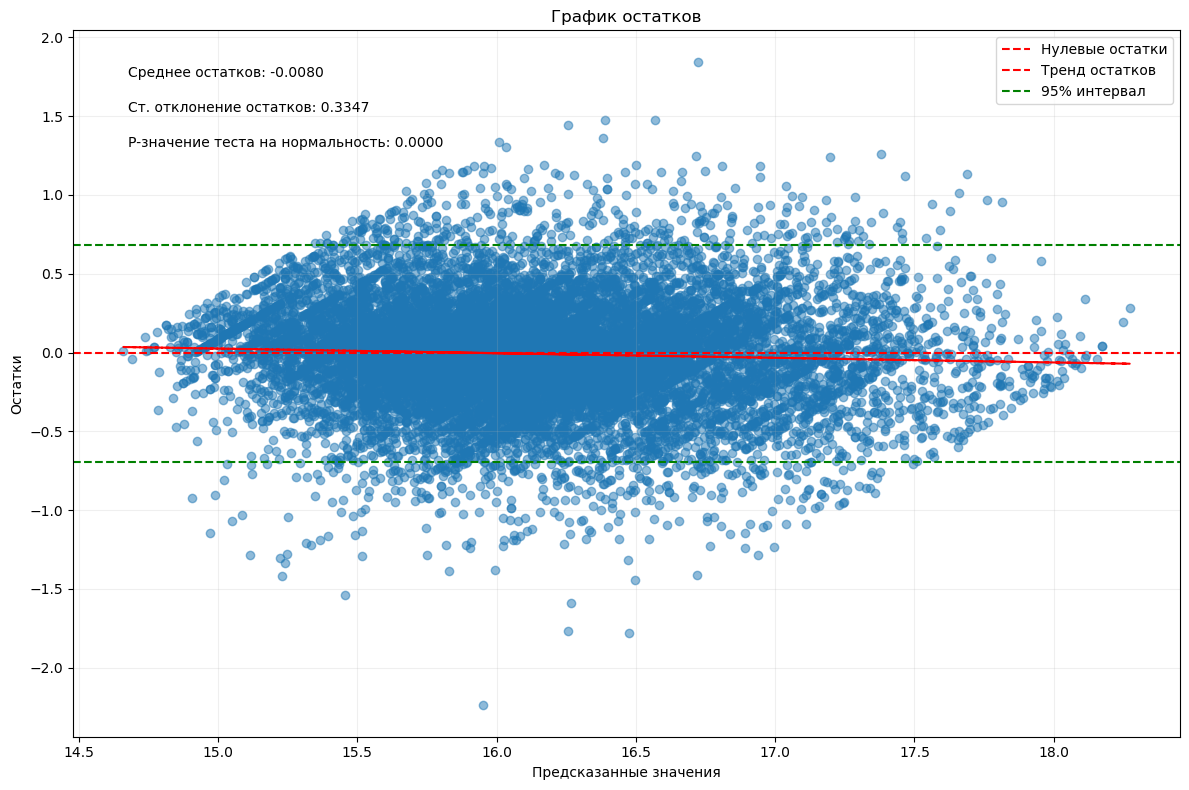

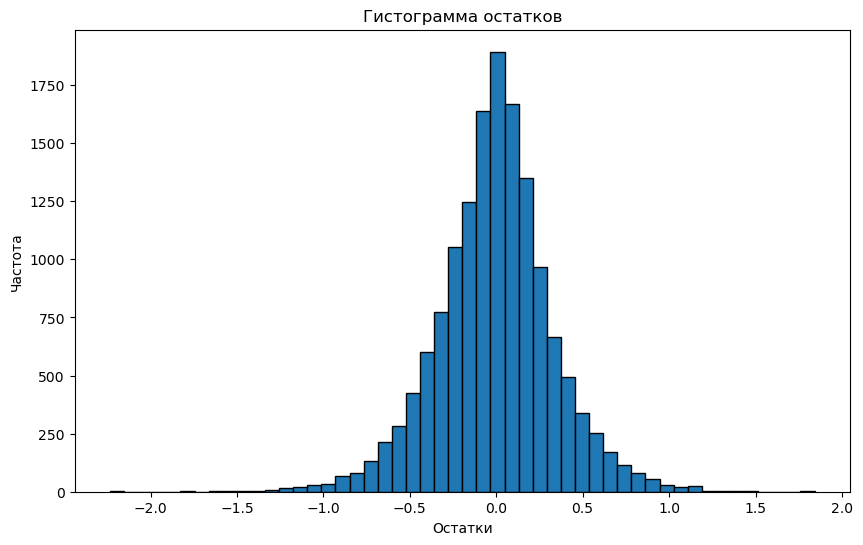

In [42]:

from scipy import stats

# Вычисляем остатки
residuals = y_pred - y_true

# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Основной график остатков
ax.scatter(y_pred, residuals, alpha=0.5)

# Добавляем линию нулевых остатков
ax.axhline(y=0, color='r', linestyle='--', label='Нулевые остатки')

# Добавляем линию тренда остатков
z = np.polyfit(y_pred, residuals, 1)
p = np.poly1d(z)
ax.plot(y_pred, p(y_pred), "r--", label='Тренд остатков')

# Добавляем границы для 95% остатков
percentiles = np.percentile(residuals, [2.5, 97.5])
ax.axhline(y=percentiles[0], color='g', linestyle='--', label='95% интервал')
ax.axhline(y=percentiles[1], color='g', linestyle='--')

# Настройка осей
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Остатки")
ax.set_title("График остатков")

# Добавляем дополнительную информацию
ax.text(0.05, 0.95, f'Среднее остатков: {np.mean(residuals):.4f}', transform=ax.transAxes, verticalalignment='top')
ax.text(0.05, 0.90, f'Ст. отклонение остатков: {np.std(residuals):.4f}', transform=ax.transAxes, verticalalignment='top')

# Проверка на нормальность распределения остатков
_, p_value = stats.normaltest(residuals)
ax.text(0.05, 0.85, f'P-значение теста на нормальность: {p_value:.4f}', transform=ax.transAxes, verticalalignment='top')

# Добавляем легенду
ax.legend()

# Добавляем сетку для удобства чтения
ax.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

# Добавим гистограмму остатков
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

In [43]:
_, p_value = stats.normaltest(residuals)
p_value

1.1014280954659432e-101